#Import

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 8.4 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 596 kB 59.3 MB/s 
     |████████████████████████████████| 895 kB 41.3 MB/s 
     |████████████████████████████████| 6.5 MB 39.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
!/opt/bin/nvidia-smi

Wed Mar 16 14:17:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

#read dataset

In [ ]:

train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/4192/Data/DirectCompare/train_df.csv")

train_df = train_df[['selftext','Expert-label']]
train_df[['Expert-label']] = train_df[['Expert-label']].astype(int)
train_df

,selftext,Expert-label
0,I posted this on Piazza but thought I might as...,1
1,"Hi i’ve applied for arts from Vancouver,BC as ...",0
2,i'm an international student and i've been tak...,1
3,i'm an international student and the midterm w...,1
4,they think i wouldnt be able to handle the str...,0
...,...,...
997,My boyfriend is Canadian and I’m American. Obv...,0
998,Do you need to be vaccinated to travel domesti...,0
999,"Hello, are there any International students he...",1
1000,Will you guys take a leave of absence? Or are ...,0


##train test split

In [ ]:
X = train_df["selftext"].values.tolist()
y = train_df["Expert-label"].values.tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


##torch dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])



##Metrics

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

#Models

##SciBERT

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

###epoch=3

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

In [ ]:
trainer_sci = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_sci.train()

***** Running training *****
  Num examples = 801
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 75


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.641874,0.616915,0.569106,0.744681,0.645161
50,No log,0.611659,0.661692,0.616071,0.734043,0.669903
75,No log,0.598196,0.681592,0.633929,0.755319,0.689320


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=0.6003725687662761, metrics={'train_runtime': 159.9043, 'train_samples_per_second': 15.028, 'train_steps_per_second': 0.469, 'total_flos': 631992754974720.0, 'train_loss': 0.6003725687662761, 'epoch': 3.0})

###epoch=6

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=6,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer_sci_6 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_sci_6.train()

***** Running training *****
  Num examples = 801
  Num Epochs = 6
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 150


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,2.070263,0.716418,0.646552,0.824176,0.724638
50,No log,2.180760,0.721393,0.654867,0.813187,0.725490
75,No log,2.002043,0.711443,0.689655,0.659341,0.674157
100,No log,1.898822,0.751244,0.746988,0.681319,0.712644
125,No log,2.221045,0.726368,0.655172,0.835165,0.734300
150,No log,2.206330,0.721393,0.652174,0.824176,0.728155


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=150, training_loss=0.046296250025431314, metrics={'train_runtime': 321.1983, 'train_samples_per_second': 14.963, 'train_steps_per_second': 0.467, 'total_flos': 1264248621004800.0, 'train_loss': 0.046296250025431314, 'epoch': 6.0})

###epoch=9

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=9,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer_sci_9 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_sci_9.train()

***** Running training *****
  Num examples = 801
  Num Epochs = 9
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 225


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,3.601378,0.621891,0.548387,0.934066,0.691057
50,No log,1.804664,0.736318,0.697917,0.736264,0.716578
75,No log,2.141430,0.731343,0.712644,0.681319,0.696629
100,No log,1.926750,0.741294,0.705263,0.736264,0.720430
125,No log,1.935593,0.731343,0.663717,0.824176,0.735294
150,No log,1.896723,0.731343,0.683168,0.758242,0.718750
175,No log,2.262177,0.716418,0.639344,0.857143,0.732394
200,No log,1.933741,0.746269,0.681818,0.824176,0.746269
225,No log,1.907876,0.721393,0.684211,0.714286,0.698925


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=225, training_loss=0.037092408074273005, metrics={'train_runtime': 481.5907, 'train_samples_per_second': 14.969, 'train_steps_per_second': 0.467, 'total_flos': 1896504487034880.0, 'train_loss': 0.037092408074273005, 'epoch': 9.0})

##PSY

In [ ]:
model_name = "nlp4good/psych-search"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/323 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlp4good/psych-search were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlp4good/psych-search a

In [ ]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

###epoch=3

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

In [ ]:
trainer_psy = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_psy.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 801
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 75


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.631535,0.636816,0.558140,0.307692,0.396694
50,No log,0.622105,0.621891,0.511905,0.551282,0.530864
75,No log,0.641439,0.597015,0.486239,0.679487,0.566845


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=0.5854359944661458, metrics={'train_runtime': 258.6812, 'train_samples_per_second': 9.289, 'train_steps_per_second': 0.29, 'total_flos': 631992754974720.0, 'train_loss': 0.5854359944661458, 'epoch': 3.0})

###epoch=6

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=6,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer_psy_6 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_psy_6.train()

***** Running training *****
  Num examples = 801
  Num Epochs = 6
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 150


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.490442,0.781095,0.733333,0.827957,0.777778
50,No log,1.375540,0.711443,0.657658,0.784946,0.715686
75,No log,1.580385,0.731343,0.675676,0.806452,0.735294
100,No log,1.785634,0.736318,0.678571,0.817204,0.741463
125,No log,1.534417,0.776119,0.740000,0.795699,0.766839
150,No log,1.583016,0.766169,0.721154,0.806452,0.761421


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=150, training_loss=0.02686001141866048, metrics={'train_runtime': 321.1493, 'train_samples_per_second': 14.965, 'train_steps_per_second': 0.467, 'total_flos': 1264248621004800.0, 'train_loss': 0.02686001141866048, 'epoch': 6.0})

###epoch=9

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=9,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer_psy_9 = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer_psy_9.train()

***** Running training *****
  Num examples = 801
  Num Epochs = 9
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 16
  Total optimization steps = 225


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,1.616690,0.796020,0.782609,0.774194,0.778378
50,No log,2.075152,0.721393,0.643411,0.892473,0.747748
75,No log,1.613216,0.746269,0.687500,0.827957,0.751220
100,No log,1.621726,0.786070,0.828947,0.677419,0.745562
125,No log,1.940256,0.701493,0.638655,0.817204,0.716981
150,No log,2.072261,0.701493,0.632000,0.849462,0.724771
175,No log,1.897928,0.716418,0.655172,0.817204,0.727273
200,No log,1.658141,0.756219,0.707547,0.806452,0.753769
225,No log,1.571159,0.771144,0.728155,0.806452,0.765306


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=225, training_loss=0.02859132766723633, metrics={'train_runtime': 481.6038, 'train_samples_per_second': 14.969, 'train_steps_per_second': 0.467, 'total_flos': 1896504487034880.0, 'train_loss': 0.02859132766723633, 'epoch': 9.0})

#Outputs

##SciBERT

###epoch=3

In [ ]:
trainer_sci.evaluate()

***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


{'epoch': 3.0,
 'eval_accuracy': 0.681592039800995,
 'eval_f1': 0.6893203883495145,
 'eval_loss': 0.5981957316398621,
 'eval_precision': 0.6339285714285714,
 'eval_recall': 0.7553191489361702,
 'eval_runtime': 4.2902,
 'eval_samples_per_second': 46.851,
 'eval_steps_per_second': 23.542}

###epoch=6

In [ ]:
trainer_sci_6.evaluate()

***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


{'epoch': 6.0,
 'eval_accuracy': 0.7213930348258707,
 'eval_f1': 0.7281553398058253,
 'eval_loss': 2.2063302993774414,
 'eval_precision': 0.6521739130434783,
 'eval_recall': 0.8241758241758241,
 'eval_runtime': 4.3236,
 'eval_samples_per_second': 46.489,
 'eval_steps_per_second': 23.36}

###epoch=9

In [ ]:
trainer_sci_9.evaluate()

***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


{'epoch': 9.0,
 'eval_accuracy': 0.7213930348258707,
 'eval_f1': 0.6989247311827957,
 'eval_loss': 1.9078761339187622,
 'eval_precision': 0.6842105263157895,
 'eval_recall': 0.7142857142857143,
 'eval_runtime': 4.3249,
 'eval_samples_per_second': 46.475,
 'eval_steps_per_second': 23.353}

##PSY

###epoch=3

In [ ]:
trainer_psy.evaluate()


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


{'epoch': 3.0,
 'eval_accuracy': 0.5970149253731343,
 'eval_f1': 0.5668449197860963,
 'eval_loss': 0.641438901424408,
 'eval_precision': 0.48623853211009177,
 'eval_recall': 0.6794871794871795,
 'eval_runtime': 7.5822,
 'eval_samples_per_second': 26.51,
 'eval_steps_per_second': 13.321}

###epoch=6

In [ ]:
trainer_psy_6.evaluate()

***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


{'epoch': 6.0,
 'eval_accuracy': 0.7661691542288557,
 'eval_f1': 0.7614213197969544,
 'eval_loss': 1.5830156803131104,
 'eval_precision': 0.7211538461538461,
 'eval_recall': 0.8064516129032258,
 'eval_runtime': 4.3324,
 'eval_samples_per_second': 46.395,
 'eval_steps_per_second': 23.313}

###epoch=9

In [ ]:
trainer_psy_9.evaluate()

***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


{'epoch': 9.0,
 'eval_accuracy': 0.7711442786069652,
 'eval_f1': 0.7653061224489796,
 'eval_loss': 1.571158528327942,
 'eval_precision': 0.7281553398058253,
 'eval_recall': 0.8064516129032258,
 'eval_runtime': 4.3211,
 'eval_samples_per_second': 46.516,
 'eval_steps_per_second': 23.374}

#epoch-test

In [ ]:
psy_epoch_range = range(3,61,3)
recall_list = []




for i in psy_epoch_range:

  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )


  args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=i,
    seed=0,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16
  )

  trainer_psy_tmp = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
  ) 

  trainer_psy_tmp.train()
  tmp_eval = trainer_psy_tmp.evaluate()
  recall_list.append(tmp_eval['eval_recall'])


loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.681670,0.502488,0.427632,0.833333,0.565217
50,No log,0.671249,0.542289,0.446970,0.756410,0.561905
75,No log,0.682867,0.567164,0.465116,0.769231,0.579710


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.611241,0.666667,0.641026,0.320513,0.427350
50,No log,0.629563,0.681592,0.557377,0.871795,0.680000
75,No log,0.539053,0.731343,0.633333,0.730769,0.678571
100,No log,0.612847,0.766169,0.666667,0.794872,0.725146
125,No log,0.674489,0.781095,0.688889,0.794872,0.738095
150,No log,0.742900,0.761194,0.663043,0.782051,0.717647


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.611757,0.666667,0.720000,0.230769,0.349515
50,No log,0.626197,0.651741,0.532258,0.846154,0.653465
75,No log,0.563470,0.756219,0.659341,0.769231,0.710059
100,No log,0.821967,0.746269,0.645161,0.769231,0.701754
125,No log,0.837730,0.726368,0.616162,0.782051,0.689266
150,No log,1.079398,0.741294,0.627451,0.820513,0.711111
175,No log,1.161636,0.741294,0.630000,0.807692,0.707865
200,No log,1.275421,0.721393,0.601852,0.833333,0.698925
225,No log,1.195110,0.746269,0.642105,0.782051,0.705202


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.623095,0.641791,0.625000,0.192308,0.294118
50,No log,0.630731,0.626866,0.512195,0.807692,0.626866
75,No log,0.583585,0.696517,0.591398,0.705128,0.643275
100,No log,0.654476,0.751244,0.655556,0.756410,0.702381
125,No log,0.810503,0.751244,0.648936,0.782051,0.709302
150,No log,1.232874,0.696517,0.570248,0.884615,0.693467
175,No log,0.986672,0.751244,0.662791,0.730769,0.695122
200,No log,1.072077,0.741294,0.647727,0.730769,0.686747
225,No log,1.227763,0.741294,0.630000,0.807692,0.707865
250,No log,1.289153,0.746269,0.636364,0.807692,0.711864


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.611906,0.696517,0.680851,0.410256,0.512000
50,No log,0.643488,0.661692,0.540984,0.846154,0.660000
75,No log,0.578855,0.731343,0.622449,0.782051,0.693182
100,No log,0.818633,0.706468,0.606742,0.692308,0.646707
125,No log,1.032930,0.711443,0.590909,0.833333,0.691489
150,No log,0.982322,0.736318,0.640449,0.730769,0.682635
175,No log,1.280890,0.696517,0.571429,0.871795,0.690355
200,No log,1.312691,0.751244,0.640000,0.820513,0.719101
225,No log,1.582865,0.681592,0.554688,0.910256,0.689320
250,No log,1.461441,0.731343,0.603448,0.897436,0.721649


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.613945,0.711443,0.692308,0.461538,0.553846
50,No log,0.601042,0.651741,0.532787,0.833333,0.650000
75,No log,0.594654,0.696517,0.584158,0.756410,0.659218
100,No log,0.875021,0.696517,0.575221,0.833333,0.680628
125,No log,1.012808,0.716418,0.612903,0.730769,0.666667
150,No log,1.151524,0.721393,0.598214,0.858974,0.705263
175,No log,1.130252,0.766169,0.678161,0.756410,0.715152
200,No log,1.295415,0.706468,0.600000,0.730769,0.658960
225,No log,1.327184,0.731343,0.617647,0.807692,0.700000
250,No log,1.484580,0.721393,0.594828,0.884615,0.711340


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.615282,0.661692,0.608696,0.358974,0.451613
50,No log,0.625142,0.681592,0.561404,0.820513,0.666667
75,No log,0.536335,0.751244,0.659091,0.743590,0.698795
100,No log,0.749827,0.736318,0.631579,0.769231,0.693642
125,No log,0.898856,0.756219,0.659341,0.769231,0.710059
150,No log,1.080506,0.731343,0.615385,0.820513,0.703297
175,No log,1.268054,0.746269,0.631068,0.833333,0.718232
200,No log,1.311802,0.721393,0.625000,0.705128,0.662651
225,No log,1.179180,0.736318,0.631579,0.769231,0.693642
250,No log,1.283782,0.766169,0.656566,0.833333,0.734463


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.637668,0.636816,0.551020,0.346154,0.425197
50,No log,0.705886,0.552239,0.455882,0.794872,0.579439
75,No log,0.630204,0.716418,0.620690,0.692308,0.654545
100,No log,0.949845,0.706468,0.592233,0.782051,0.674033
125,No log,0.964317,0.731343,0.627660,0.756410,0.686047
150,No log,1.278176,0.686567,0.571429,0.769231,0.655738
175,No log,1.227233,0.726368,0.626374,0.730769,0.674556
200,No log,1.386260,0.721393,0.630952,0.679487,0.654321
225,No log,1.519457,0.686567,0.563025,0.858974,0.680203
250,No log,1.561675,0.701493,0.586538,0.782051,0.670330


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.628395,0.641791,0.537500,0.551282,0.544304
50,No log,0.586052,0.666667,0.563218,0.628205,0.593939
75,No log,0.545722,0.741294,0.651163,0.717949,0.682927
100,No log,0.754052,0.746269,0.648352,0.756410,0.698225
125,No log,0.833784,0.741294,0.618182,0.871795,0.723404
150,No log,0.920709,0.736318,0.634409,0.756410,0.690058
175,No log,1.079493,0.756219,0.670588,0.730769,0.699387
200,No log,1.161939,0.716418,0.603960,0.782051,0.681564
225,No log,1.040186,0.751244,0.652174,0.769231,0.705882
250,No log,1.356008,0.726368,0.611650,0.807692,0.696133


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.628971,0.641791,0.650000,0.166667,0.265306
50,No log,0.689730,0.557214,0.460432,0.820513,0.589862
75,No log,0.528945,0.746269,0.651685,0.743590,0.694611
100,No log,0.743189,0.741294,0.647727,0.730769,0.686747
125,No log,0.853859,0.731343,0.611111,0.846154,0.709677
150,No log,1.264154,0.666667,0.544715,0.858974,0.666667
175,No log,1.008084,0.751244,0.637255,0.833333,0.722222
200,No log,1.283704,0.751244,0.634615,0.846154,0.725275
225,No log,1.054519,0.756219,0.655914,0.782051,0.713450
250,No log,1.479467,0.696517,0.573913,0.846154,0.683938


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.635564,0.671642,0.772727,0.217949,0.340000
50,No log,0.583718,0.666667,0.557895,0.679487,0.612717
75,No log,0.607982,0.681592,0.557377,0.871795,0.680000
100,No log,0.995524,0.661692,0.535211,0.974359,0.690909
125,No log,0.896037,0.696517,0.564885,0.948718,0.708134
150,No log,1.511101,0.601990,0.493506,0.974359,0.655172
175,No log,0.840321,0.756219,0.640777,0.846154,0.729282
200,No log,0.972534,0.731343,0.607143,0.871795,0.715789
225,No log,1.010618,0.761194,0.659574,0.794872,0.720930
250,No log,1.163429,0.751244,0.627273,0.884615,0.734043


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.595858,0.711443,0.661290,0.525641,0.585714
50,No log,0.549147,0.716418,0.623529,0.679487,0.650307
75,No log,0.563924,0.731343,0.642857,0.692308,0.666667
100,No log,0.830835,0.716418,0.606061,0.769231,0.677966
125,No log,0.894190,0.726368,0.613861,0.794872,0.692737
150,No log,0.941738,0.746269,0.658824,0.717949,0.687117
175,No log,1.256403,0.731343,0.615385,0.820513,0.703297
200,No log,1.178726,0.746269,0.639175,0.794872,0.708571
225,No log,1.235564,0.736318,0.623762,0.807692,0.703911
250,No log,1.289490,0.741294,0.618182,0.871795,0.723404


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.630247,0.641791,0.537500,0.551282,0.544304
50,No log,0.583872,0.696517,0.589474,0.717949,0.647399
75,No log,0.542331,0.746269,0.675325,0.666667,0.670968
100,No log,0.772924,0.731343,0.627660,0.756410,0.686047
125,No log,0.895234,0.721393,0.601852,0.833333,0.698925
150,No log,1.136330,0.691542,0.568966,0.846154,0.680412
175,No log,1.066114,0.741294,0.635417,0.782051,0.701149
200,No log,1.084227,0.771144,0.705128,0.705128,0.705128
225,No log,1.118921,0.771144,0.663265,0.833333,0.738636
250,No log,1.306214,0.706468,0.590476,0.794872,0.677596


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/nlp4good/psych-search/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/daeea662c4b48e2b660049ca9c884af1818b56fa516e63fe8d4674fbd72c421c.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/4a6fc3ad007c72a596ffe4cf1d5dfa0fa19dbb098481747e6757d602eedc30c3.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/nlp4good/psych-search/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/a861b08ab06b2a37194482cab468fe6bdfa40d1d760b4ae79744356068b102d7.e096ff0acc3183b627fd32953445a2a87dcb1eb6082c2897afd3dbb797efb7ba
loading configuration file https://huggingface.co/nlp4good/psych-search/resol

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.630840,0.636816,0.530864,0.551282,0.540881
50,No log,0.568611,0.686567,0.586207,0.653846,0.618182
75,No log,0.531124,0.736318,0.666667,0.641026,0.653595
100,No log,0.809213,0.731343,0.627660,0.756410,0.686047
125,No log,0.923999,0.731343,0.617647,0.807692,0.700000
150,No log,1.361375,0.646766,0.527559,0.858974,0.653659
175,No log,1.165870,0.761194,0.687500,0.705128,0.696203
200,No log,1.133297,0.751244,0.675000,0.692308,0.683544
225,No log,1.103261,0.726368,0.626374,0.730769,0.674556
250,No log,1.358454,0.751244,0.648936,0.782051,0.709302


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

KeyboardInterrupt: ignored

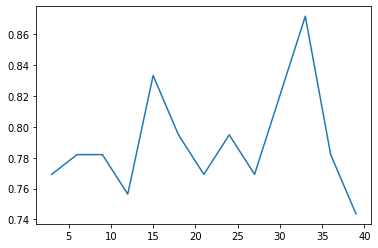

In [ ]:
plt.plot(range(3,42,3),recall_list)

In [ ]:
print(max(recall_list))

0.8717948717948718


In [ ]:
sci_epoch_range = range(3,31,3)
sci_recall_list = []




for i in sci_epoch_range:

  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )


  
  args = TrainingArguments(
      output_dir="output",
      evaluation_strategy="steps",
      eval_steps=25,
      per_device_train_batch_size=2,
      per_device_eval_batch_size=2,
      num_train_epochs=i,
      seed=0,
      load_best_model_at_end=True,
      overwrite_output_dir=True,
      learning_rate=3e-5,
      gradient_accumulation_steps=16
  )

  trainer_sci_tmp = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
  ) 

  trainer_sci_tmp.train()
  tmp_eval = trainer_sci_tmp.evaluate()
  sci_recall_list.append(tmp_eval['eval_recall'])


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.616511,0.636816,0.580645,0.433735,0.496552
50,No log,0.594900,0.671642,0.571429,0.819277,0.673267
75,No log,0.550046,0.711443,0.654321,0.638554,0.646341


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.645609,0.592040,0.523810,0.132530,0.211538
50,No log,0.637897,0.621891,0.527132,0.819277,0.641509
75,No log,0.574719,0.681592,0.743590,0.349398,0.475410
100,No log,0.552826,0.741294,0.644860,0.831325,0.726316
125,No log,0.626575,0.741294,0.642202,0.843373,0.729167
150,No log,0.620787,0.736318,0.647059,0.795181,0.713514


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.631577,0.611940,0.522523,0.698795,0.597938
50,No log,0.608117,0.646766,0.546875,0.843373,0.663507
75,No log,0.579865,0.701493,0.621053,0.710843,0.662921
100,No log,0.657839,0.671642,0.573913,0.795181,0.666667
125,No log,0.722918,0.706468,0.607143,0.819277,0.697436
150,No log,0.759083,0.731343,0.643564,0.783133,0.706522
175,No log,0.875152,0.716418,0.620370,0.807229,0.701571
200,No log,0.861620,0.726368,0.632075,0.807229,0.708995
225,No log,0.975915,0.701493,0.600000,0.831325,0.696970


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.608811,0.656716,0.568627,0.698795,0.627027
50,No log,0.531065,0.751244,0.698795,0.698795,0.698795
75,No log,0.550929,0.696517,0.617021,0.698795,0.655367
100,No log,0.600568,0.746269,0.656863,0.807229,0.724324
125,No log,0.747919,0.721393,0.617391,0.855422,0.717172
150,No log,0.915270,0.736318,0.633929,0.855422,0.728205
175,No log,0.954884,0.736318,0.638889,0.831325,0.722513
200,No log,0.869182,0.781095,0.767123,0.674699,0.717949
225,No log,1.037396,0.736318,0.638889,0.831325,0.722513
250,No log,0.989170,0.736318,0.650000,0.783133,0.710383


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.623453,0.631841,0.539130,0.746988,0.626263
50,No log,0.563788,0.706468,0.657895,0.602410,0.628931
75,No log,0.630781,0.671642,0.579439,0.746988,0.652632
100,No log,0.560007,0.786070,0.738095,0.746988,0.742515
125,No log,0.859764,0.706468,0.607143,0.819277,0.697436
150,No log,0.649138,0.800995,0.794521,0.698795,0.743590
175,No log,0.771219,0.776119,0.702128,0.795181,0.745763
200,No log,0.734753,0.805970,0.775000,0.746988,0.760736
225,No log,1.009595,0.761194,0.657658,0.879518,0.752577
250,No log,1.050173,0.731343,0.630631,0.843373,0.721649


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.621023,0.656716,0.571429,0.674699,0.618785
50,No log,0.579836,0.706468,0.615385,0.771084,0.684492
75,No log,0.527762,0.781095,0.819672,0.602410,0.694444
100,No log,0.711985,0.716418,0.618182,0.819277,0.704663
125,No log,0.662450,0.746269,0.660000,0.795181,0.721311
150,No log,0.853177,0.761194,0.710843,0.710843,0.710843
175,No log,1.005821,0.741294,0.650485,0.807229,0.720430
200,No log,0.907926,0.786070,0.750000,0.722892,0.736196
225,No log,1.254929,0.711443,0.605042,0.867470,0.712871
250,No log,1.243197,0.706468,0.601695,0.855422,0.706468


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.640644,0.592040,0.513514,0.228916,0.316667
50,No log,0.588663,0.676617,0.591837,0.698795,0.640884
75,No log,0.536195,0.741294,0.829787,0.469880,0.600000
100,No log,0.622451,0.746269,0.660000,0.795181,0.721311
125,No log,0.779103,0.761194,0.657658,0.879518,0.752577
150,No log,0.850402,0.731343,0.638095,0.807229,0.712766
175,No log,0.869809,0.781095,0.701031,0.819277,0.755556
200,No log,0.967494,0.756219,0.774194,0.578313,0.662069
225,No log,1.576949,0.641791,0.538462,0.927711,0.681416
250,No log,0.983241,0.766169,0.687500,0.795181,0.737430


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.631795,0.616915,0.536585,0.530120,0.533333
50,No log,0.570805,0.696517,0.619565,0.686747,0.651429
75,No log,0.521665,0.741294,0.731343,0.590361,0.653333
100,No log,0.560959,0.751244,0.689655,0.722892,0.705882
125,No log,0.821374,0.711443,0.619048,0.783133,0.691489
150,No log,0.944500,0.721393,0.633663,0.771084,0.695652
175,No log,1.169887,0.721393,0.645161,0.722892,0.681818
200,No log,1.082768,0.781095,0.774648,0.662651,0.714286
225,No log,1.455410,0.691542,0.586777,0.855422,0.696078
250,No log,1.210984,0.721393,0.633663,0.771084,0.695652


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.626353,0.646766,0.585714,0.493976,0.535948
50,No log,0.587604,0.706468,0.642857,0.650602,0.646707
75,No log,0.580239,0.716418,0.608333,0.879518,0.719212
100,No log,0.652937,0.736318,0.641509,0.819277,0.719577
125,No log,1.049434,0.671642,0.561151,0.939759,0.702703
150,No log,1.183051,0.686567,0.581967,0.855422,0.692683
175,No log,1.101745,0.716418,0.618182,0.819277,0.704663
200,No log,1.104203,0.726368,0.659091,0.698795,0.678363
225,No log,1.540152,0.661692,0.556391,0.891566,0.685185
250,No log,0.941384,0.791045,0.788732,0.674699,0.727273


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,No log,0.621259,0.681592,0.600000,0.686747,0.640449
50,No log,0.550076,0.716418,0.732143,0.493976,0.589928
75,No log,0.570356,0.726368,0.634615,0.795181,0.705882
100,No log,0.597047,0.751244,0.660194,0.819277,0.731183
125,No log,1.056519,0.691542,0.582677,0.891566,0.704762
150,No log,0.859084,0.741294,0.686747,0.686747,0.686747
175,No log,1.162889,0.726368,0.634615,0.795181,0.705882
200,No log,1.163048,0.761194,0.830189,0.530120,0.647059
225,No log,1.348636,0.676617,0.568182,0.903614,0.697674
250,No log,0.934565,0.756219,0.693182,0.734940,0.713450


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  N

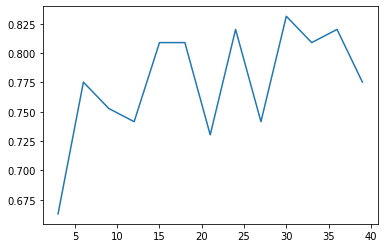

In [ ]:
plt.plot(range(3,42,3),sci_recall_list)

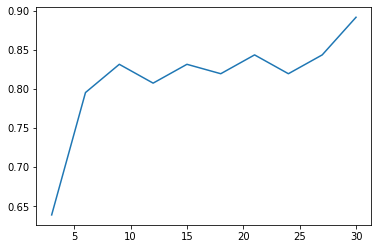

In [ ]:
plt.plot(range(3,31,3),sci_recall_list)